In [1]:
# !pip install vega_datasets
# !pip install -U altair
# !pip install -U jupyter notebook
# !pip install -U vega
# !jupyter nbextension install --sys-prefix --py vega
# !jupyter nbextension enable vega --py --sys-prefix

In [2]:
# for SEIR
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
# import plotly.express as px
import seaborn as sns
import numpy as np
import re
from IPython.display import display
from ipywidgets import interact

# alt.data_transformers.enable('default', max_rows=10_000_000)
# alt.data_transformers.enable('json')
alt.data_transformers.enable('data_server')
# alt.renderers.enable('notebook')
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

# Fetch datasets

In [4]:
isocodes = pd.read_csv('../input/countries-iso-codes/wikipedia-iso-country-codes.csv')
isocodes.columns = isocodes.columns.str.replace(' ', '_').str.lower()
isocodes = isocodes.rename({"english_short_name_lower_case": 'country_name'}, axis=1)
isocodes

,country_name,alpha-2_code,alpha-3_code,numeric_code,iso_3166-2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX
2,Albania,AL,ALB,8,ISO 3166-2:AL
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16,ISO 3166-2:AS
...,...,...,...,...,...
241,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF
242,Western Sahara,EH,ESH,732,ISO 3166-2:EH
243,Yemen,YE,YEM,887,ISO 3166-2:YE
244,Zambia,ZM,ZMB,894,ISO 3166-2:ZM


In [5]:
ecdc = (pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
        .assign(date=lambda f: f['date'].pipe(pd.to_datetime))
       )

ecdc.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [33]:
populations_country = ecdc.assign(population = lambda f: f['new_cases'].div(f['new_cases_per_million']).mul(1_000_000)).groupby('location')['population'].last()
populations_country.loc['United States'], populations_country.loc['France'], populations_country.loc['Germany']

(331003968.54741305, 65269715.41837746, 83786008.23045267)

In [7]:
from io import StringIO
import requests

# url = 'https://covid19-static.cdn-apple.com/covid19-mobility-data/2006HotfixDev13/v1/en-us/applemobilitytrends-2020-04-22.csv'
url = 'https://covid19-static.cdn-apple.com/covid19-mobility-data/2006HotfixDev17/v1/en-us/applemobilitytrends-2020-04-25.csv'
response = requests.get(url)
apple_mobility = (pd.read_csv(StringIO(response.content.decode()))
                  .set_index(['geo_type', 'region', 'transportation_type'])
                  .rename_axis("date", axis=1)
                  .stack()
                  .rename('change')
                  .reset_index('date')
                  .assign(date=lambda f: pd.to_datetime(f['date']))
                  .set_index('date', append=True)
                  )

location_code = ecdc.groupby(['location', 'iso_code']).first().iloc[:, 0].reset_index().iloc[:,:2]
apple_mobility = (apple_mobility
                  .reset_index()
                  .replace({'UK': 'United Kingdom', 'Republic of Korea': 'South Korea', 'Macao': 'Macau'})  # Only missing is Macao
                  .merge(location_code, left_on='region', right_on='location', how='left')
                 .assign(change=lambda f: f['change'].div(100).sub(1)))
apple_mobility

,geo_type,region,transportation_type,date,change,location,iso_code
0,country/region,Albania,driving,2020-01-13,0.0000,Albania,ALB
1,country/region,Albania,driving,2020-01-14,-0.0470,Albania,ALB
2,country/region,Albania,driving,2020-01-15,0.0143,Albania,ALB
3,country/region,Albania,driving,2020-01-16,-0.0280,Albania,ALB
4,country/region,Albania,driving,2020-01-17,0.0355,Albania,ALB
...,...,...,...,...,...,...,...
41075,city,Zurich,walking,2020-04-21,-0.3382,NaN,NaN
41076,city,Zurich,walking,2020-04-22,-0.2765,NaN,NaN
41077,city,Zurich,walking,2020-04-23,-0.2636,NaN,NaN
41078,city,Zurich,walking,2020-04-24,-0.2328,NaN,NaN


In [8]:
mobility = (pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")
            .assign(date=lambda f: f['date'].pipe(pd.to_datetime))
           )

def safe_match(pat, text):
    match = re.match(pat, text)
    return match.groups()[0] if match else text

mobility.columns = mobility.columns.map(lambda col: safe_match("(.*)_percent", col))
mobility = (mobility
            .merge(isocodes, left_on='country_region_code', right_on='alpha-2_code', how='left')
            .merge(location_code, left_on='alpha-3_code', right_on='iso_code', how='left'))
mobility

C:\Users\Horace\miniconda3\envs\uncover\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,country_name,alpha-2_code,alpha-3_code,numeric_code,iso_3166-2,location,iso_code
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0,United Arab Emirates,AE,ARE,784,ISO 3166-2:AE,United Arab Emirates,ARE
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0,United Arab Emirates,AE,ARE,784,ISO 3166-2:AE,United Arab Emirates,ARE
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0,United Arab Emirates,AE,ARE,784,ISO 3166-2:AE,United Arab Emirates,ARE
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0,United Arab Emirates,AE,ARE,784,ISO 3166-2:AE,United Arab Emirates,ARE
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0,United Arab Emirates,AE,ARE,784,ISO 3166-2:AE,United Arab Emirates,ARE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230823,ZW,Zimbabwe,NaN,NaN,2020-04-13,-71.0,-63.0,-51.0,-83.0,-80.0,49.0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW,Zimbabwe,ZWE
230824,ZW,Zimbabwe,NaN,NaN,2020-04-14,-63.0,-53.0,-47.0,-78.0,-64.0,41.0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW,Zimbabwe,ZWE
230825,ZW,Zimbabwe,NaN,NaN,2020-04-15,-62.0,-50.0,-51.0,-77.0,-65.0,42.0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW,Zimbabwe,ZWE
230826,ZW,Zimbabwe,NaN,NaN,2020-04-16,-62.0,-50.0,-48.0,-77.0,-64.0,42.0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW,Zimbabwe,ZWE


In [9]:
mobility_country = (mobility
                    .loc[lambda f: f['sub_region_1'].isna()]
                    .set_index(mobility.select_dtypes('object').columns.tolist() + ['numeric_code', 'date'])
                    .rename_axis('mobility_category', axis=1)
                    .stack()
                    .div(100)
                    .to_frame('change')
#                     .query('mobility_category == "workplaces"')
                    .iloc[:, 0]
                   )
mobility_country.to_frame()

change
country_region_code country_region       sub_region_1 sub_region_2 country_name         alpha-2_code alpha-3_code iso_3166-2    location             iso_code numeric_code date       mobility_category            
AE                  United Arab Emirates NaN          NaN          United Arab Emirates AE           ARE          ISO 3166-2:AE United Arab Emirates ARE      784          2020-02-15 retail_and_recreation    0.00
                                                                                                                                                                                      grocery_and_pharmacy     0.04
                                                                                                                                                                                      parks                    0.05
                                                                                                                                                                                      transit_stations         0.00
                                                                                                                                                                                      workplaces               0.02
...                                                                                                                                                                                                             ...
ZW                  Zimbabwe             NaN          NaN          Zimbabwe             ZW           ZWE          ISO 3166-2:ZW Zimbabwe             ZWE      716          2020-04-17 grocery_and_pharmacy    -0.48
                                                                                                                                                                                      parks                   -0.47
                                                                                                                                                                                      transit_stations        -0.79
                                                                                                                                                                                      workplaces              -0.62
                                                                                                                                                                                      residential              0.43

[48765 rows x 1 columns]

In [10]:
url = "https://data.humdata.org/dataset/e1a91ae0-292d-4434-bc75-bf863d4608ba/resource/065de281-0ba9-45aa-badc-fc46db61af04/download/20200423-acaps-covid-19-goverment-measures-dataset-v10.xlsx"
# response = requests.get(url)
# measures = pd.read_excel("20200423-acaps-covid-19-goverment-measures-dataset-v10.xlsx", sheet_name='Database')
measures = pd.read_excel(url, sheet_name='Database')
measures.columns = measures.columns.str.lower()
measures

,id,country,iso,admin_level_name,pcode,region,log_type,category,measure,targeted_pop_group,comments,non_compliance,date_implemented,source,source_type,link,entry_date,alternative source
0,1,Afghanistan,AFG,NaN,NaN,Asia,Introduction / extension of measures,Public health measures,Health screenings in airports and border cross...,No,NaN,NaN,2020-02-12,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,2020-03-14,NaN
1,2,Afghanistan,AFG,Kabul,NaN,Asia,Introduction / extension of measures,Public health measures,Introduction of isolation and quarantine policies,No,NaN,NaN,2020-02-12,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,2020-03-14,NaN
2,3,Afghanistan,AFG,NaN,NaN,Asia,Introduction / extension of measures,Public health measures,Awareness campaigns,No,NaN,NaN,2020-02-12,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,2020-03-14,NaN
3,4,Afghanistan,AFG,NaN,NaN,Asia,Introduction / extension of measures,Governance and socio-economic measures,Emergency administrative structures activated ...,No,NaN,NaN,2020-02-12,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,2020-03-14,NaN
4,5,Afghanistan,AFG,NaN,NaN,Asia,Introduction / extension of measures,Social distancing,Limit public gatherings,No,Nevruz festival cancelled,NaN,2020-03-12,AA,Media,https://www.aa.com.tr/en/asia-pacific/coronavi...,2020-03-14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7074,4303,Zimbabwe,ZWE,NaN,NaN,Africa,Phase-out measure,Public health measures,Other public health measures enforced,No,Zimbabwe reversed a ban on the sale of alcohol...,Not applicable,2020-04-03,BBC,Media,https://www.bbc.com/news/topics/crr7mlg0rpvt/z...,2020-04-07,NaN
7075,4646,Zimbabwe,ZWE,NaN,NaN,Africa,Introduction / extension of measures,Governance and socio-economic measures,State of emergency declared,No,"Declaration of State of Disaster, 17 March",Not applicable,2020-03-17,ONHCR Document,UN,See ACAPS folder,2020-04-10,NaN
7076,5420,Zimbabwe,ZWE,NaN,NaN,Africa,Introduction / extension of measures,Public health measures,Testing policy,No,Zimbabwe begins mass testing with the aim to e...,Not applicable,2020-04-15,BBC,Media,https://www.bbc.com/news/world/africa/live,2020-04-15,NaN
7077,5421,Zimbabwe,ZWE,NaN,NaN,Africa,Introduction / extension of measures,Governance and socio-economic measures,Emergency administrative structures activated ...,No,The Ministry has launched a tollfree helpline ...,Not applicable,2020-04-14,Ministry of Information,Social media,https://twitter.com/MinOfInfoZW/status/1250037...,2020-04-15,NaN


In [11]:
measures.iloc[0]

id                                                                    1
country                                                     Afghanistan
iso                                                                 AFG
admin_level_name                                                    NaN
pcode                                                               NaN
region                                                             Asia
log_type                           Introduction / extension of measures
category                                         Public health measures
measure               Health screenings in airports and border cross...
targeted_pop_group                                                   No
comments                                                            NaN
non_compliance                                                      NaN
date_implemented                                    2020-02-12 00:00:00
source                                               Ministry of

In [12]:
measures.category.value_counts()

Public health measures                    2436
Movement restrictions                     1649
Governance and socio-economic measures    1394
Social distancing                         1271
Lockdown                                   327
Humanitarian exemption                       2
Name: category, dtype: int64

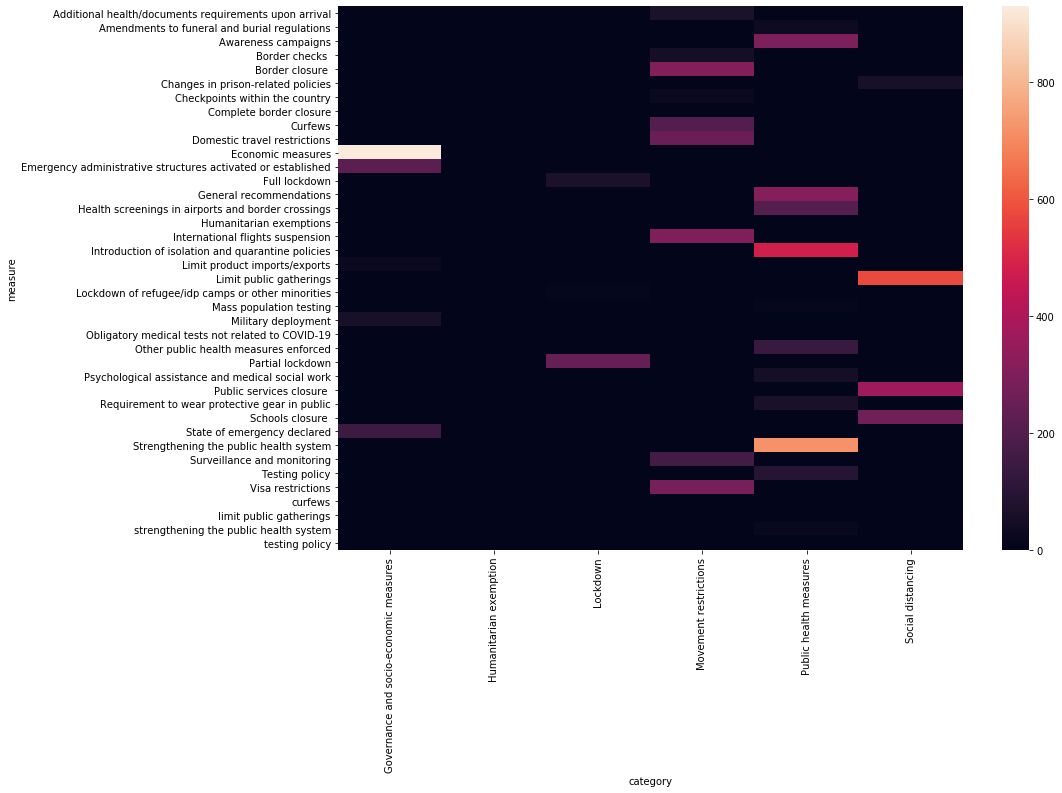

In [13]:
plt.subplots(figsize=(14, 10))
pd.crosstab(measures.measure, measures.category).pipe(sns.heatmap)


In [14]:
some_measures = (measures
                      .loc[lambda f: 
                           ~f['category'].isin(['Governance and socio-economic measures', 'Public health measures']) 
#                            & f['source_type'].eq('Government') 
#                            & f['admin_level_name'].isna()
                          ]
                 .fillna({'admin_level_name': 'Global'})
                     )


In [15]:
ecdc_nona = ecdc[['date', 'iso_code', 'location', 'new_cases']].assign(new_cases=lambda f: f['new_cases'].replace(0, np.nan)).dropna()

ts_data = (ecdc_nona
           .merge(some_measures[['iso', 'measure', 'category', 'log_type', 'admin_level_name', 'comments', 'date_implemented', 'link']], 
                     left_on=['iso_code', 'date'], right_on=['iso', 'date_implemented'], how='outer')
           .merge(isocodes[['alpha-3_code', 'alpha-2_code']], left_on='iso_code', right_on='alpha-3_code', how='outer')
           .merge(mobility_country.to_frame().query('mobility_category == "workplaces"').reset_index()
                  [['change', 'mobility_category', 'country_region_code', 'country_region', 'date']], 
                  left_on=['alpha-2_code', 'date'], right_on=['country_region_code', 'date'], how='left', indicator=True)
          )
ts_data.loc[lambda f: f['alpha-2_code'].isna()].country_region.value_counts()
ts_data.shape

(9445, 19)

# Viz

## Measures, new_cases, mobility

In [16]:
from vega_datasets import data
from IPython.display import display

counties = alt.topo_feature(data.world_110m.url, 'countries')

# lockdown_map_data = lockdown_countries.groupby('iso').last().reset_index()
ecdc_map_data = ecdc.groupby('iso_code').last().reset_index()[['iso_code', 
                                                    'new_cases',
                                                    'new_cases_per_million', 
                                                    'total_cases',
                                                    'total_cases_per_million',
                                                    'location']]

map_data = ecdc_map_data.merge(isocodes, left_on='iso_code', right_on='alpha-3_code', how='outer')


color_field = 'new_cases_per_million:Q'

selection_country = alt.selection_multi(fields=['location'], init=[{'location': 'France'}], empty='all')
selection_country_2 = alt.selection_multi(fields=['location'], init=[{'location': 'France'}], empty='none')
selection_country_3 = alt.selection_multi(fields=['location'], init=[{'location': 'France'}], empty='all')

selection_rule = alt.selection_single(fields=['date'], nearest=True, on='mouseover', 
#                                       clear='mouseout'
                                     )
selection_legend = alt.selection_multi(fields=['category'], bind='legend')

map_chart = (alt.Chart(counties).mark_geoshape(stroke='white', strokeWidth=0.5).encode(
    tooltip=['location:N', color_field],
    color=alt.condition(
        selection_country, 
        alt.Color(color_field, scale=alt.Scale(scheme='oranges', type='symlog', base=10), legend=alt.Legend(orient='top-right')),
        alt.value('lightgray')
    )
).transform_filter(
    'datum.id != 10 & datum.id != 304'
)
             .add_selection(selection_country)
             .add_selection(selection_country_2)
             .add_selection(selection_country_3)
.transform_lookup(
    lookup='id',
    from_=alt.LookupData(map_data, 'numeric_code', ['country_name', 
                                                    'new_cases',
                                                    'new_cases_per_million', 
                                                    'total_cases',
                                                    'total_cases_per_million',
                                                    'location'
                                                   ])
).properties(
    width=800,
#     height=500
))


base = (alt.Chart(ts_data).encode(x='date:T').properties(width=600))

# date_domain = alt.selection_interval(bind='scales', encodings=['x'])

lines = (base
            .mark_line(color='black')
            .encode(
                y=alt.Y('new_cases', axis=alt.Axis(title='New cases', titleColor='black')))
         .add_selection(selection_country)
         .transform_filter(selection_country)
         .transform_aggregate(
                new_cases='sum(new_cases)',
                groupby=['date'])
#          .add_selection(date_domain)
        )

mobility_chart = (base
                  .mark_line(color='green')
                  .encode(y=alt.Y('change', axis=alt.Axis(title='Mobility change', format='%', titleColor='green')), )
                  .add_selection(selection_country_3)
                  .transform_filter(selection_country_3)
                  .transform_aggregate(
                      change='mean(change)',
                      groupby=['date']
                  )
                 )

measures_chart = (base
#           .mark_point(filled=True, size=50)
#           .mark_tick(thickness=2, size=300)
                  .mark_rule(size=2)
          .transform_filter('datum.measure != null')
          .encode(
#               y='new_cases', 
              tooltip=['location', 'date:T', 'measure', 'category', 'log_type', 'admin_level_name', 'comments', 'link'], 
              href='link:N',
              strokeDash=alt.StrokeDash('category:N', legend=None),
              color=alt.condition(selection_rule | selection_legend, alt.Color('category:N', legend=alt.Legend(orient='right')), alt.value('lightgray')))
          .add_selection(selection_country_2)
          .transform_filter(selection_country_2)
                           .add_selection(selection_rule)
                  .add_selection(selection_legend)
#                   .transform_filter(selection_legend)
# .add_selection(date_domain)
#           .properties(height=100)
         )

chart = (map_chart 
 &
 (
     measures_chart +
     (mobility_chart + lines).resolve_scale(y='independent').properties(height=300)
 ).resolve_scale(x='shared')
)

chart

alt.VConcatChart(...)

## Measures, all mobility categories, new cases

In [17]:
from vega_datasets import data
from IPython.display import display


input_dropdown = alt.binding_select(options=sorted(ts_data['location'].dropna().unique().tolist()))
selection_country_dropdown = alt.selection_single(fields=['location'],  bind=input_dropdown, name='Location', init={'location': 'France'}, empty='all')

selection_rule = alt.selection_single(fields=['date'], nearest=True, on='mouseover', clear='mouseout')
selection_legend = alt.selection_multi(fields=['category'], bind='legend')
selection_legend_mobility = alt.selection_multi(fields=['mobility_category'], bind='legend')
selection_legend_apple_mobility = alt.selection_multi(fields=['transportation_type'], bind='legend')

base = (alt.Chart(ts_data).encode(x='date:T').properties(width=700))#.add_selection(selection_country_dropdown)


lines = (base
            .mark_line()
            .encode(
                y=alt.Y('new_cases', axis=alt.Axis(title='New cases')),
                color=alt.value('black'))
         .transform_filter(selection_country_dropdown)
         .transform_aggregate(
                new_cases='sum(new_cases)',
                groupby=['date'])
#          .add_selection(date_domain)
        )

mobility_chart_data = (mobility_country
    .reset_index()
#     .merge(ecdc
#            .groupby('location', as_index=False)
#            .first()
#            [['location', 'iso_code']]
#            .merge(isocodes[['alpha-3_code', 'alpha-2_code']], 
#                   left_on='iso_code', 
#                   right_on='alpha-3_code', 
#                   how='outer'),
#           left_on='country_region_code', right_on='alpha-2_code')
                      )

mobility_axis = alt.Axis(title='Mobility change', format='%')

mobility_chart = (alt.Chart(mobility_chart_data)
                  .mark_line()
                  .encode(
                      x='date:T',
                      y=alt.Y('change',
                                  axis=mobility_axis), 
                          color=
                      alt.condition(selection_legend_mobility, 
                                              'mobility_category',
                                              alt.value('lightgray'))
                  )
#                   .add_selection(selection_country_dropdown_cases)
                  .transform_filter(selection_country_dropdown)
                  .add_selection(selection_legend_mobility)
#                   .transform_aggregate(
#                       change='mean(change)',
#                       groupby=['date']
#                   )
                 )

apple_mobility_chart = (
    alt.Chart(apple_mobility)
    .mark_line()
    .encode(x='date:T', 
            y=alt.Y('change', axis=mobility_axis),
            color=alt.condition(selection_legend_apple_mobility, 
                                              'transportation_type',
                                              alt.value('lightgray'))
           )
    .transform_filter(selection_country_dropdown)
    .add_selection(selection_legend_apple_mobility)
)

measures_chart = (base
#           .mark_point(filled=True, size=50)
#           .mark_tick(thickness=2, size=300)
                  .mark_rule(size=2)
          .transform_filter('datum.measure != null')
          .encode(
#               y='new_cases', 
              tooltip=['location', 'date:T', 'measure', 'category', 'log_type', 'admin_level_name', 'comments', 'link'], 
              href='link:N',
              strokeDash=alt.StrokeDash('category:N'),
              color=alt.condition(selection_rule | selection_legend, 
                                  alt.Color('category:N'), alt.value('lightgray')))
#           .add_selection(selection_country_dropdown_measures)
          .transform_filter(selection_country_dropdown)
                           .add_selection(selection_rule)
                  .add_selection(selection_legend)
#                   .transform_filter(selection_legend)
# .add_selection(date_domain)
#           .properties(height=100)
         )

chart = (
    measures_chart &
 (mobility_chart
#   + measures_chart
    +
    apple_mobility_chart
 ).resolve_legend(color='independent')
    & 
    (
#         measures_chart 
#      + 
        lines
    )
).resolve_scale(x='shared').add_selection(selection_country_dropdown).resolve_legend(color='independent')

# chart

## Mobility categories, new_cases

In [18]:
(mobility_chart + lines).add_selection(selection_country_dropdown).properties(width=800).resolve_scale(y='independent')

alt.LayerChart(...)

# Merging ECDC, Apple and Google datasets

In [19]:
full = (ecdc.set_index(['iso_code', 'location', 'date']).rename_axis('ecdc_cat', axis=1).drop('tests_units', axis=1).stack().rename('value').unstack(-1)
        .merge(mobility_country.unstack(-1), 
               on=['location', 'date'], 
               how='outer', 
#                indicator='goog'
              )
        .merge(apple_mobility.loc[lambda f: f['location'].notna()].set_index(['location', 'date', 'transportation_type'])['change'].unstack(-1), 
               on=['location', 'date'], 
#                indicator='apple', 
               how='outer')
        .rename_axis('variable', axis=1)
        .stack()
        .rename('value')
        .sort_index()
        .to_frame()
        .query('location == location')
        .iloc[:, 0]
       )

# Correlation: lagged mobility and new cases 

_What is the timeframe of an effective lockdown ?_  
Measures which result in a drop in mobility rates have a **delayed** impact on virus transmission. How long is this period of transition ?

We implement here a simple approach: we **lag** the _mew cases_ time-series by a number of days, and compute the **correlation** with the _mobility_ series.  

Since the measures are usually implemented amidst the exponential growth phase of the pandemic, we see a high _negative_ correlation for no lag or a few days : this is to be ignored.  
What interests us is the _positive_ correlation, which typically happens $\simeq 30$ days afterwards.

In [20]:
import ppscore as pps
ix = pd.IndexSlice

mobility_categories = ['workplaces', 'parks', 'retail_and_recreation', 'transit_stations', 'transit', 'driving', 'walking']
def compute_score(cases, mob, shift, method='corr'):
    shifted_mob = mob.shift(freq=f'{shift}d')
    if method == 'pps':
        return pps.score(cases.to_frame('new_cases').join(shifted_mob), 
                         'mobility', 
                         'new_cases', 
                         sample=None, 
                         task='regression')['ppscore']
    elif method == 'corr':
        return cases.corr(shifted_mob)
    else:
        raise ValueError('Score not understood')

@interact(country=full.reset_index()['location'].unique().tolist(), 
          method=['pps', 'corr'],
          category=mobility_categories
         )
def plot_corr(country='France', method='corr', category='transit'):
    subset = full.loc[country]
    
    mob = subset.loc[ix[:, category]].rename('mobility').rolling('7d').mean()
    cases = subset.loc[ix[:, 'new_cases']].replace(0, np.nan).rolling('7d').mean()
    len_mob = mob.shape[0]
    len_cases = cases.dropna().shape[0]
    corr_length = min([70, len_mob, len_cases])
    s = pd.Series({
        i: compute_score(cases, mob, i, method=method)
        for i in range(0, corr_length, 2)
    }).to_frame().plot.bar(figsize=(10, 5), legend=False)
    plt.grid()
    plt.xlabel("lag (days)")
    plt.title(f"Correlation between {category} mobility and lagged new_cases\n{country}")

# plot_corr()

interactive(children=(Dropdown(description='country', index=67, options=('Afghanistan', 'Albania', 'Algeria', …

# SEIR Model

## Model

We use a [SEIR-HCD](https://www.kaggle.com/anjum48/seir-hcd-model) model, with typical parameters found in the literature.

We model without interventation at first, then with an arbitrary drop in $R_t$, the _effective reproduction number_, and finally with a simple dependance of $R_t$ on the mobility rate in the specified country.

In [21]:
# Susceptible equation
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S


# Exposed equation
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)


# Infected equation
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)


# Hospialized equation
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a):
    return ((1 - m_a) * (I / t_inf)) + ((1 - f_a) * C / t_crit) - (H / t_hosp)


# Critical equation
def dC_dt(H, C, t_hosp, t_crit, c_a):
    return (c_a * H / t_hosp) - (C / t_crit)


# Recovered equation
def dR_dt(I, H, t_inf, t_hosp, m_a, c_a):
    return (m_a * I / t_inf) + (1 - c_a) * (H / t_hosp)


# Deaths equation
def dD_dt(C, t_crit, f_a):
    return f_a * C / t_crit


def SEIR_HCD_model(t, y, R_t, t_inc=2.9, t_inf=5.2, t_hosp=4, t_crit=14, m_a=0.8, c_a=0.1, f_a=0.3):
    """

    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Reproduction number
    :param t_inc: Average incubation period. Default 5.2 days
    :param t_inf: Average infectious period. Default 2.9 days
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical. Default 4 days
    :param t_crit: Average time a patient is in a critical state (either recover or die). Default 14 days
    :param m_a: Fraction of infections that are asymptomatic or mild. Default 0.8
    :param c_a: Fraction of severe cases that turn critical. Default 0.1
    :param f_a: Fraction of critical cases that are fatal. Default 0.3
    :return:
    """
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t
        
    S, E, I, R, H, C, D = y
    
    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, m_a, c_a)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a)
    C_out = dC_dt(H, C, t_hosp, t_crit, c_a)
    D_out = dD_dt(C, t_crit, f_a)
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

## Plot model

In [22]:
def plot_model(solution, population=1., time_axis=None, title='SEIR+HCD model'):
    if population == 1. :
        pop_format = '.2%'
    else:
        pop_format = ',.0f'
    time_axis = np.arange(solution.y[0].shape[0]) if time_axis is None else time_axis
    sus, exp, inf, rec, hosp, crit, death = solution.y
    
    df = pd.DataFrame({
        'Exposed': exp,
        'Infected': inf,
        'Recovered': rec, 
        'Hospitalised': hosp,
        'Critical': crit,
        'Deceased': death
    }).set_index(time_axis).rename_axis('time').rename_axis('status', axis=1).stack().rename('population').mul(population).reset_index()
    
    columns = sorted(df.status.unique())
    selection_tooltip = alt.selection_single(
        fields=['time'], nearest=True, on='mouseover', empty='none', clear='mouseout', name='test'
    )

    selection_legend = alt.selection_multi(fields=['status'], bind='legend')
    base = alt.Chart(df).encode(x='time')
    lines = (base
                         .mark_line()
                         .encode(
#                              x='time', 
                                 y='population', 
                                 color=alt.condition(selection_legend, 'status', alt.value('lightgray'))
#                              color='status'
                         )
                        )
    points = lines.mark_point().transform_filter(selection_tooltip)

    rule = base.transform_pivot(
        'status', value='population', groupby=['time']
    ).mark_rule().encode(
        opacity=alt.condition(selection_tooltip, alt.value(0.3), alt.value(0)),
        tooltip=[alt.Tooltip(c, type='quantitative', format=pop_format) for c in columns]
    ).add_selection(selection_tooltip)

    compartment_chart = (lines + points + rule).add_selection(selection_legend).properties(height=200)

    cases_chart = (alt.Chart(df.query('status != "Exposed"').groupby('time', as_index=False).sum())
                   .mark_line(point=True)
                   .encode(x='time', 
                           y=alt.Y('population', axis=alt.Axis(title='Cases', titleColor='red')),
                           tooltip=['time', alt.Tooltip('population', format=pop_format)],
                           color=alt.value('red')
                          )
                  )
    deaths_chart = (alt.Chart(df.query('status == "Deceased"'))
                    .mark_line(point=True)
                    .encode(x='time', 
                            y=alt.Y('population', axis=alt.Axis(title='Deaths')), 
                            tooltip=['time', alt.Tooltip('population', format=pop_format)],
                            color=alt.value('black')
                           )
                   )
    chart =  compartment_chart & (cases_chart.interactive() + deaths_chart.interactive()).resolve_scale(y='independent').properties(height=200)
    display(chart.properties(title=title).configure_title(anchor='middle').configure_point(size=20))

## Without intervention


Parameters used in the model

R_t = reproduction number at time t. Typical 3.6* at t=0

Transition times

    T_inc = average incubation period. Typical 5.6* days
    T_inf = average infectious period. Typical 2.9 days
    T_hosp = average time a patient is in hospital before either recovering or becoming critical. Typical 4 days
    T_crit = average time a patient is in a critical state (either recover or die). Typical 14 days

Fractions  
These constants are likely to be age specific (hence the subscript a):

    m_a = fraction of infections that are asymptomatic or mild. Assumed 80% (i.e. 20% severe)
    c_a = fraction of severe cases that turn critical. Assumed 10%
    f_a = fraction of critical cases that are fatal. Assumed 30%
    
*Averages taken from https://www.kaggle.com/covid-19-contributions

In [23]:
N = 60_000_000  # Population size
n_infected = 500
max_days = 100

# State at time = 0 for SEIR_HCD model
# The numbers correspond to the number of people in each of the SEIRHCD compartments
def compute_intial_state(n_infected, population):
    return [(population - n_infected)/ population, 0, n_infected / population, 0, 0, 0, 0]

initial_state = compute_intial_state(n_infected, N)
R_0 = 3.6
t_inc = 5.6
t_inf = 2.9
t_hosp = 4
t_crit = 5
m_a = 0.8
c_a = 0.1
f_a = 0.35

args = (R_0, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

pop = 1.
plot_model(sol, pop, title='SEIR-HCD Model (without intervention)')

alt.VConcatChart(...)

## Intervention (punctual)

In [24]:
R_0 = 3.6 # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention
for intervention_day in range(45, 46, 10):
    def time_varying_reproduction(t):
        if t < intervention_day:
            return R_0
        else:
            return R_t

    args = (time_varying_reproduction, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

    sol2 = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

    plot_model(sol2, pop, title=f'SEIR-HCD Model (with intervention on day {intervention_day})')

alt.VConcatChart(...)

## R(t) = f(mobility(t))

In [35]:
ix = pd.IndexSlice

@interact(country=full.reset_index()['location'].unique().tolist(), 
          nb_first_cases=(100, 1000, 100), 
          days_delay=[0, 7, 14, 21], 
          category=mobility_categories
         )
def plot_sim_country(country='France', nb_first_cases=100, days_delay=0, category='transit'):
    N = populations_country.loc[country]
    n_infected = 4000
    max_days = 100

    initial_state = compute_intial_state(n_infected, N)

    subset = full.loc[country]
    first_infected = subset.loc[ix[:, 'total_cases']].gt(nb_first_cases).cumsum().loc[lambda x: x == 1].index[0] - pd.Timedelta(days_delay, unit='days')
    mobi = (subset
            .loc[ix[:, category]]
            .loc[first_infected:]
            .rolling('7d')
            .mean()
            .shift(freq='0d')
            .fillna(0.)
           )

    max_days = mobi.shape[0]-1

    R_0 = 3.6 # reproduction number without intervention
    R_1 = 0.7 # reproduction number after intervention

    def time_varying_reproduction(t):
        return R_0 * (1 + mobi.iloc[int(t)]) - mobi.iloc[int(t)] * R_1
#         return R_0

    args = (time_varying_reproduction, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

    sol2 = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

    plot_model(sol2, populations_country.loc[country], time_axis=mobi.index[1:], title=f'SEIR-HCD Model with mobility, for {country}')

    display(alt.Chart(pd.DataFrame({'time': mobi.index[1:], 'R_t': pd.Series(np.arange(max_days)).apply(time_varying_reproduction)}))
            .mark_line(point=True)
            .encode(x='time:T', y='R_t:Q', tooltip=['time', alt.Tooltip('R_t', format='.2f')])
            .properties(height=200)
            .configure_point(size=30)
           )

# plot_sim_country()

interactive(children=(Dropdown(description='country', index=67, options=('Afghanistan', 'Albania', 'Algeria', …

# Optimization of SEIR model

In [186]:
pivot_date = '2020-04-01'
full_cases = full.to_frame().query('variable in ("total_cases", "total_deaths")').iloc[:, 0]
train = full_cases.loc[ix[:, :pivot_date]]
valid = full_cases.loc[ix[:, pivot_date:]]
train.shape, valid.shape

((16678,), (11070,))

In [482]:
pivot_date = '2020-04-15'
full_cases = full.unstack()[['total_cases', 'total_deaths']].rename({'total_cases': 'ConfirmedCases', 'total_deaths': "Fatalities"}, axis=1).replace(0, np.nan).dropna()
train = full_cases.loc[ix[:, :pivot_date], :]
valid = full_cases.loc[ix[:, (pd.Timestamp(pivot_date) + pd.Timedelta(1, unit='days')):], :]
train.shape, valid.shape

((4143, 2), (2008, 2))

In [490]:
OPTIM_DAYS = 10  # Number of days to use for the optimisation evaluation

In [563]:
def eval_model_decay(params, data, population, mobi, return_solution=False, forecast_days=0):
    R_0, n_inf, t_hosp, t_crit, m, c, f, R_1 = params  
    N = population
    n_infected = n_inf * 1000
    max_days = len(data) + forecast_days

    def time_varying_reproduction(t):
#         return R_0 
#         return R_0 / (1 + (t/L)**k)
        time_point = int(t) - 1
        if time_point >= mobi.shape[0]:
            print(time_point)
        return R_0 * (1 + mobi.iloc[time_point]) - mobi.iloc[time_point] * R_1
    
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    args = (time_varying_reproduction, 5.6, 2.9, t_hosp, t_crit, m, c, f)

    sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred_cases = np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population
    y_true_cases = data['ConfirmedCases'].values
    y_pred_fat = np.clip(deaths, 0, np.inf) * population
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(OPTIM_DAYS, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
#     msle_cases = (y_true_cases[-optim_days:] <= y_pred_cases[-optim_days:]).mean()  # check if the number of cases is higher than reported
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
#     msle_final = msle_fat
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [564]:
def plot_model_results(y_pred, train_data, valid_data=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    
    ax1.set_title('Confirmed Cases')
    ax2.set_title('Fatalities')
    
    train_data['ConfirmedCases'].plot(label='Confirmed Cases (train)', color='g', ax=ax1)
    y_pred.loc[train_data.index, 'ConfirmedCases'].plot(label='Modeled Cases', color='r', ax=ax1)
    ax3 = y_pred['R'].plot(label='Reproduction number', color='c', linestyle='-', secondary_y=True, ax=ax1)
    ax3.set_ylabel("Reproduction number", fontsize=10, color='c');
        
    train_data['Fatalities'].plot(label='Fatalities (train)', color='g', ax=ax2)
    y_pred.loc[train_data.index, 'Fatalities'].plot(label='Modeled Fatalities', color='r', ax=ax2)
    
    y_pred.loc[:, 'ConfirmedCases'].plot(label='Modeled Cases (forecast)', color='r', linestyle=':', ax=ax1)
    y_pred.loc[:, 'Fatalities'].plot(label='Modeled Fatalities (forecast)', color='r', linestyle=':', ax=ax2)

    if valid_data is not None:
        valid_data['ConfirmedCases'].plot(label='Confirmed Cases (valid)', color='g', linestyle=':', ax=ax1)
        valid_data['Fatalities'].plot(label='Fatalities (valid)', color='g', linestyle=':', ax=ax2)
        y_pred.loc[valid_data.index, 'ConfirmedCases'].plot(label='Modeled Cases (forecast)', color='r', linestyle=':', ax=ax1)
        y_pred.loc[valid_data.index, 'Fatalities'].plot(label='Modeled Fatalities (forecast)', color='r', linestyle=':', ax=ax2)
    else:
        y_pred.loc[:, 'ConfirmedCases'].plot(label='Modeled Cases (forecast)', color='r', linestyle=':', ax=ax1)
        y_pred.loc[:, 'Fatalities'].plot(label='Modeled Fatalities (forecast)', color='r', linestyle=':', ax=ax2)
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    

m_a = fraction of infections that are asymptomatic or mild. Assumed 80% (i.e. 20% severe)  
c_a = fraction of severe cases that turn critical. Assumed 10%  
f_a = fraction of critical cases that are fatal. Assumed 30%

In [612]:
def safe_loc(mobi, t, default):
    try:
        return mobi.loc[t]
    except KeyError:
        return default

def fit_model(area_name, 
                     initial_guess=[3.6, 0.1, 4, 14, 0.8, 0.1, 0.3, 0.7],
                     bounds=((2., 5.), # R_0 bounds
                             (.02, 1.), # n_inf
                             (0.5, 10.), # t_hosp
                             (2., 10.), # t_crit
                             (0.5, .85), (0.1, .9), (.1, .9), # m c f
                             (0.2, .7) # R_1
                            ), # fraction time param bounds
                     make_plot=True):
    
    train_data = train.loc[area_name]
    valid_data = valid.loc[area_name]
    mobi = full.loc[area_name].loc[ix[:, 'transit']].rolling('7d').mean()
    mobi = mobi.loc[train_data.index[0]:].reindex(train_data.index.union(valid_data.index)).replace(np.nan, 0).shift(freq='0d')
#     display(mobi, train_data, valid_data)

#     test_data = test_public.loc[area_name]  
    
#     try:
    population = populations_country.loc[area_name]
#     except KeyError:
#         population = country_lookup[area_name]
        
    n_infected = train_data['ConfirmedCases'].iloc[0]
                
#     res_const = minimize(eval_model_const, initial_guess[:-2], bounds=bounds[:-2],
#                          args=(train_data, population, False),
#                          method='L-BFGS-B')
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, mobi, False),
                         method='L-BFGS-B'
                        )
    
#     dates_all = train_data.index.append(test_data.index)
    dates_val = train_data.index.union(valid_data.index)
    
    
    # If using a constant R number is better, use that model
    msle, sol = eval_model_decay(res_decay.x, train_data, population, mobi, True, len(valid_data))
    res = res_decay

    # Calculate the R_t values
#     time_range = np.arange(len(dates_val))
    R_0, n_inf, t_hosp, t_crit, m, c, f, R_1 = res.x
    
    R_t = pd.Series([R_0 * (1 + safe_loc(mobi, t, 0)) - safe_loc(mobi, t, 0) * R_1 for t in dates_val], dates_val)
        
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population,
        'Fatalities': np.clip(deaths, 0, np.inf) * population,
        'R': R_t,
    }, index=dates_val)
    
    y_pred_valid = y_pred.iloc[len(train_data): len(train_data)+len(valid_data)]
    y_pred_test = y_pred.iloc[len(train_data):]
    y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]
        
    valid_msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid['ConfirmedCases'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    
    if make_plot:
        print(f'Validation MSLE: {valid_msle:0.5f}')
        print(f'R: {R_0:0.3f}, t_hosp: {t_hosp:0.3f}, t_crit: {t_crit:0.3f}, '
              f'm: {m:0.3f}, c: {c:0.3f}, f: {f:0.3f}', f'R_1: {R_1:0.3f}', f'n_inf: {n_inf*1000:,.0f}')
        plot_model_results(y_pred, train_data, valid_data)
        
    # Put the forecast in the submission
#     forecast_ids = test_data['ForecastId']
#     submission.loc[forecast_ids, ['ConfirmedCases', 'Fatalities']] = y_pred_test[['ConfirmedCases', 'Fatalities']].values
    
    plot_model(sol, population=populations_country.loc[area_name], time_axis=mobi.index)
    return valid_msle


Validation MSLE: 0.00774
R: 2.554, t_hosp: 3.955, t_crit: 9.965, m: 0.539, c: 0.658, f: 0.721 R_1: 0.396 n_inf: 105


alt.VConcatChart(...)

0.007738268145755789

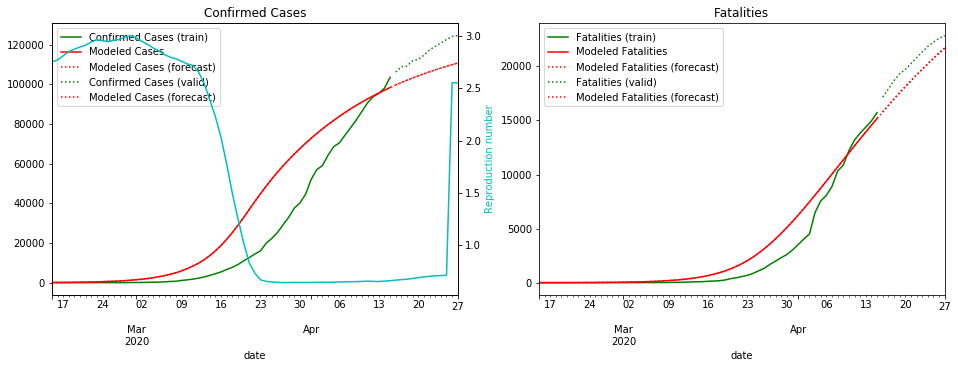

In [613]:
fit_model('France')

Validation MSLE: 0.00703
R: 3.982, t_hosp: 3.893, t_crit: 9.908, m: 0.595, c: 0.654, f: 0.581 R_1: 0.215 n_inf: 698


alt.VConcatChart(...)

0.007025114283342154

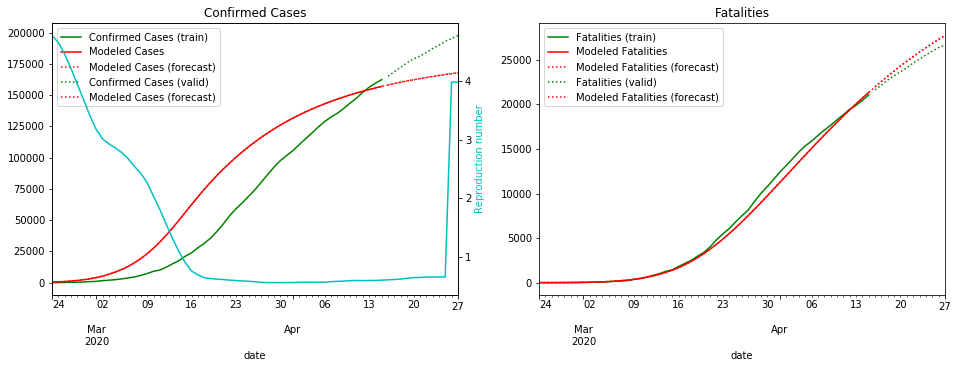

In [614]:
fit_model("Italy")

Validation MSLE: 0.01108
R: 4.220, t_hosp: 3.814, t_crit: 9.851, m: 0.663, c: 0.761, f: 0.650 R_1: 0.458 n_inf: 714


alt.VConcatChart(...)

0.01108007944606637

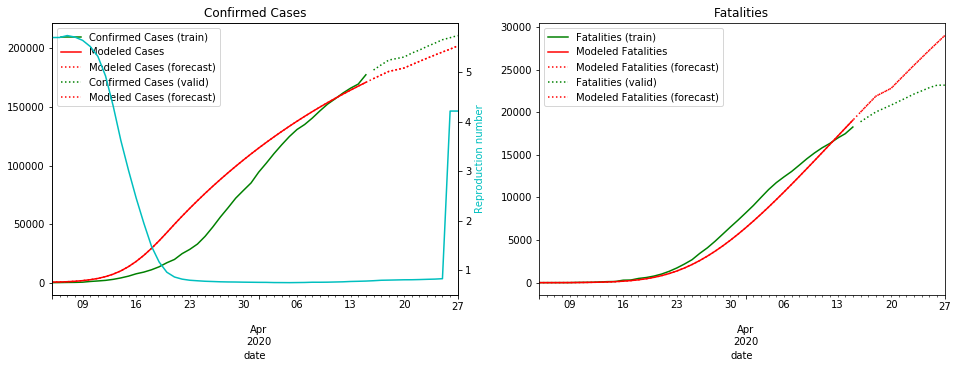

In [615]:
fit_model('Spain')

In [4]:
import numpyro.distributions as dist